# Deep BSDE
Hedging option can be formulated as a BSDE problem:


This code is copy pasted and modified from:
https://github.com/YifanJiang233/Deep_BSDE_solver/tree/master.

Do I have to add a MIT license?

Note that the paper 

[1] E, W., Han, J., and Jentzen, A. Deep learning-based numerical methods for high-dimensional parabolic partial differential equations and backward stochastic differential equations, Communications in Mathematics and Statistics, 5, 349–380 (2017).

is referenced but no subnetworks are used but a network that also takes in time. 
The actual implementation is for 

https://arxiv.org/pdf/2101.01869.pdf

[2] Jiang,Y., Li, J. Convergence of the deep bsde method for fbsdes with non-lipschitz coefficients.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class fbsde():
    def __init__(self, x_0, b, sigma, f, g, T, dim_x,dim_y,dim_d, guess_y_0 = [0,1] ):
        self.x_0 = x_0.to(device)
        self.b = b
        self.sigma = sigma
        self.f = f
        self.g = g
        self.T = T
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_d = dim_d
        self.guess_y_0 = guess_y_0 # range


class Model(nn.Module):
    def __init__(self, equation, dim_h):
        super(Model, self).__init__()
        self.equation= equation

        # specifying parameters of NN
        l = torch.rand(equation.dim_y, device=device)
        self.y_0 = nn.Parameter(equation.guess_y_0[0]*l+ equation.guess_y_0[1]*(1-l))
        self.linear1 = nn.Linear(equation.dim_x+1, dim_h) # dim_x + 1  the extra 1 for time
        self.linear2 = nn.Linear(dim_h, dim_h)
        self.linear3 = nn.Linear(dim_h, dim_h)
        self.linear4 = nn.Linear(dim_h, equation.dim_y*equation.dim_d)
        self.bn1 =nn.BatchNorm1d(dim_h)
        self.bn2 =nn.BatchNorm1d(dim_h)
    
    def get_z(self,x,t):
        tmp = torch.cat((x, t*torch.ones(x.size()[0], 1,device=device)), 1)
        tmp = F.gelu(self.linear1(tmp))
        tmp = self.bn1(F.gelu(self.linear2(tmp)))
        tmp = self.bn2(F.gelu(self.linear3(tmp)))
        return self.linear4(tmp).reshape(-1, self.equation.dim_y, self.equation.dim_d)
        

    def forward(self,batch_size, N):
        dt = self.equation.T / N
        x = self.equation.x_0+torch.zeros(batch_size,self.equation.dim_x,device=device)
        y = self.y_0+torch.zeros(batch_size,self.equation.dim_y,device=device)

        for i in range(N):
            t = dt*i
            z = self.get_z(x,t)

            dW = torch.randn(batch_size, self.equation.dim_d, 1, device=device) * np.sqrt(dt)
            x = x+self.equation.b(t, x, y)*dt+torch.matmul( self.equation.sigma(t, x), dW).reshape(-1, self.equation.dim_x)
            y = y-self.equation.f(t, x, y, z)*dt + torch.matmul(z, dW).reshape(-1, self.equation.dim_y)
        return x, y



class BSDEsolver():
    def __init__(self, equation, dim_h):
        self.model = Model(equation,dim_h).to(device)
        self.equation = equation

    def train(self, batch_size, N, itr, log):
        criterion = torch.nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(self.model.parameters())
        loss_data, y0_data = [], []

        for i in range(itr):
            x, y = self.model(batch_size,N)
            loss = criterion(self.equation.g(x), y)
            loss_data.append(float(loss))
            y0_data.append(float(self.model.y_0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if log  and i%int(itr/20) == 0:
                print(f"loss: {float(loss):7.2f} y0: {float(self.model.y_0):7.2f} done: {i/itr*100:5.2f}% Iteration: {i}")
        return loss_data, y0_data
            

In [9]:
mu = 0.07
sig = 0.3
r = 0.02
K = 110
dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 1, 1, 1, 11, 10, 1000, 1000
guess_y_0 = [15,17]

x_0, T = 100*torch.ones(dim_x), 1


def b(t, x, y):
    return mu*x


def sigma(t, x):
    return sig*x.reshape(batch_size, dim_x, dim_d)

#f_american doesnt work
def f_american(t, x, y, z):
    return (-r*y + r*K* (y<=g(x))).reshape(batch_size, dim_y)

def f_europian(t, x, y, z):
    return (-r*y ).reshape(batch_size, dim_y)


def g(x):
    return torch.max(K-x, torch.zeros(batch_size, dim_y, device=device)) 


equation = fbsde(x_0, b, sigma, f_europian, g, T,dim_x, dim_y, dim_d, guess_y_0)

bsde_solver = BSDEsolver(equation, dim_h)

loss:  335.93 y0:   15.99 done:  0.00% Iteration: 0
loss:  304.18 y0:   15.95 done:  5.00% Iteration: 50
loss:  304.18 y0:   15.90 done: 10.00% Iteration: 100
loss:  287.90 y0:   15.87 done: 15.00% Iteration: 150
loss:  262.11 y0:   15.83 done: 20.00% Iteration: 200
loss:  267.02 y0:   15.79 done: 25.00% Iteration: 250
loss:  261.06 y0:   15.75 done: 30.00% Iteration: 300
loss:  226.00 y0:   15.72 done: 35.00% Iteration: 350
loss:  344.67 y0:   15.68 done: 40.00% Iteration: 400
loss:  230.78 y0:   15.64 done: 45.00% Iteration: 450
loss:  235.53 y0:   15.60 done: 50.00% Iteration: 500
loss:  165.04 y0:   15.56 done: 55.00% Iteration: 550
loss:  205.75 y0:   15.52 done: 60.00% Iteration: 600
loss:  101.74 y0:   15.48 done: 65.00% Iteration: 650
loss:  104.29 y0:   15.44 done: 70.00% Iteration: 700
loss:  111.01 y0:   15.41 done: 75.00% Iteration: 750
loss:   75.05 y0:   15.37 done: 80.00% Iteration: 800
loss:  123.38 y0:   15.34 done: 85.00% Iteration: 850
loss:   87.26 y0:   15.30 done:

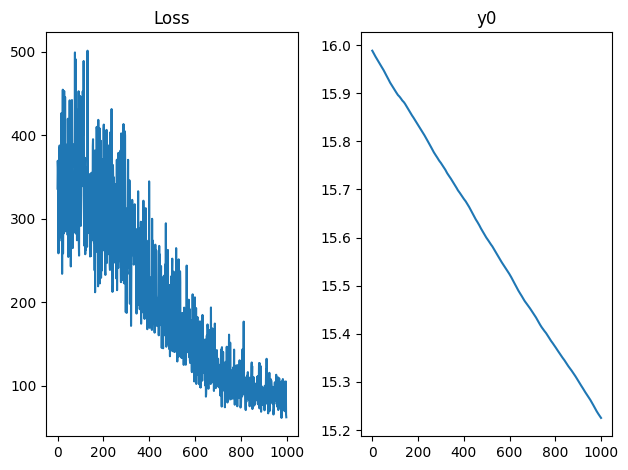

loss:  119.42 y0:   15.23 done:  0.00% Iteration: 0
loss:   49.86 y0:   15.18 done:  5.00% Iteration: 50
loss:   66.61 y0:   15.14 done: 10.00% Iteration: 100
loss:   45.94 y0:   15.09 done: 15.00% Iteration: 150
loss:   57.53 y0:   15.05 done: 20.00% Iteration: 200
loss:   47.31 y0:   15.01 done: 25.00% Iteration: 250
loss:   67.31 y0:   14.96 done: 30.00% Iteration: 300
loss:   57.79 y0:   14.92 done: 35.00% Iteration: 350
loss:   48.52 y0:   14.88 done: 40.00% Iteration: 400
loss:   56.16 y0:   14.84 done: 45.00% Iteration: 450
loss:   38.50 y0:   14.81 done: 50.00% Iteration: 500
loss:   60.83 y0:   14.77 done: 55.00% Iteration: 550
loss:   55.48 y0:   14.73 done: 60.00% Iteration: 600
loss:   54.76 y0:   14.70 done: 65.00% Iteration: 650
loss:   41.29 y0:   14.67 done: 70.00% Iteration: 700
loss:   48.75 y0:   14.63 done: 75.00% Iteration: 750
loss:   50.06 y0:   14.60 done: 80.00% Iteration: 800
loss:   54.11 y0:   14.57 done: 85.00% Iteration: 850
loss:   64.74 y0:   14.54 done:

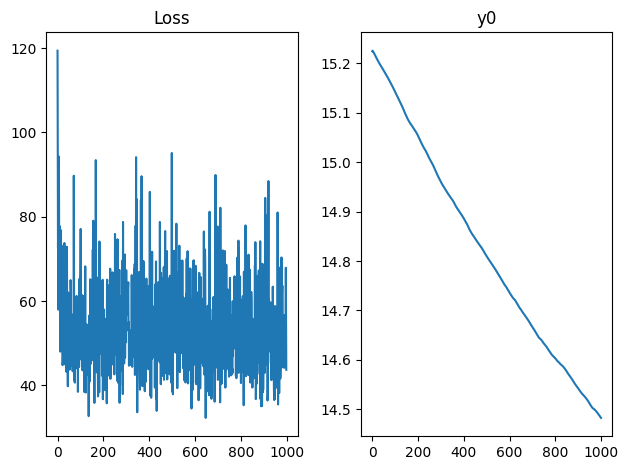

loss:   35.59 y0:   14.48 done:  0.00% Iteration: 0
loss:   29.92 y0:   14.47 done:  5.00% Iteration: 25
loss:   23.68 y0:   14.45 done: 10.00% Iteration: 50
loss:   22.87 y0:   14.44 done: 15.00% Iteration: 75
loss:   21.37 y0:   14.42 done: 20.00% Iteration: 100
loss:   27.55 y0:   14.41 done: 25.00% Iteration: 125
loss:   16.96 y0:   14.39 done: 30.00% Iteration: 150
loss:   25.98 y0:   14.38 done: 35.00% Iteration: 175
loss:   32.15 y0:   14.37 done: 40.00% Iteration: 200
loss:   31.10 y0:   14.35 done: 45.00% Iteration: 225
loss:   23.29 y0:   14.35 done: 50.00% Iteration: 250
loss:   30.07 y0:   14.34 done: 55.00% Iteration: 275
loss:   31.15 y0:   14.33 done: 60.00% Iteration: 300
loss:   22.86 y0:   14.31 done: 65.00% Iteration: 325
loss:   26.93 y0:   14.30 done: 70.00% Iteration: 350
loss:   20.98 y0:   14.29 done: 75.00% Iteration: 375
loss:   21.18 y0:   14.28 done: 80.00% Iteration: 400
loss:   29.45 y0:   14.27 done: 85.00% Iteration: 425
loss:   26.47 y0:   14.26 done: 9

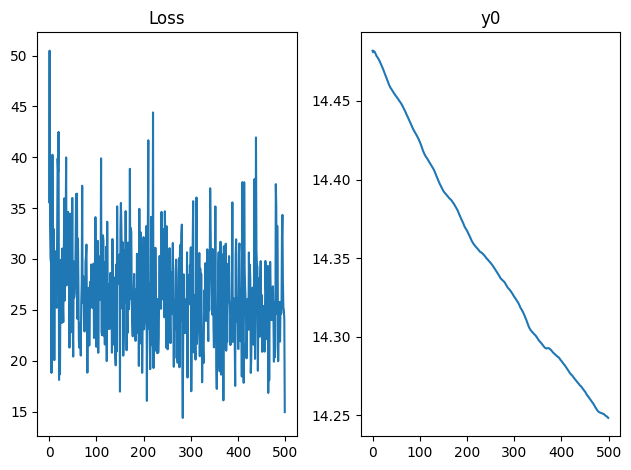

loss:   18.18 y0:   14.25 done:  0.00% Iteration: 0
loss:   16.18 y0:   14.23 done:  5.00% Iteration: 25
loss:   13.83 y0:   14.22 done: 10.00% Iteration: 50
loss:   21.01 y0:   14.21 done: 15.00% Iteration: 75
loss:   20.70 y0:   14.20 done: 20.00% Iteration: 100
loss:   17.19 y0:   14.19 done: 25.00% Iteration: 125
loss:   18.09 y0:   14.19 done: 30.00% Iteration: 150
loss:   15.14 y0:   14.18 done: 35.00% Iteration: 175
loss:   13.56 y0:   14.17 done: 40.00% Iteration: 200
loss:   10.54 y0:   14.17 done: 45.00% Iteration: 225
loss:   13.31 y0:   14.17 done: 50.00% Iteration: 250
loss:   15.24 y0:   14.16 done: 55.00% Iteration: 275
loss:   11.71 y0:   14.15 done: 60.00% Iteration: 300
loss:   12.66 y0:   14.14 done: 65.00% Iteration: 325
loss:   12.69 y0:   14.13 done: 70.00% Iteration: 350
loss:   12.02 y0:   14.13 done: 75.00% Iteration: 375
loss:   12.58 y0:   14.12 done: 80.00% Iteration: 400
loss:   15.36 y0:   14.11 done: 85.00% Iteration: 425
loss:   12.19 y0:   14.11 done: 9

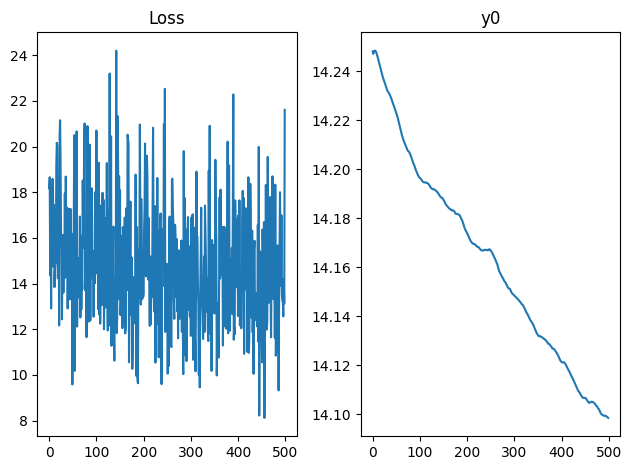

loss:    9.38 y0:   14.10 done:  0.00% Iteration: 0
loss:    8.58 y0:   14.10 done:  5.00% Iteration: 10
loss:    8.99 y0:   14.10 done: 10.00% Iteration: 20
loss:    7.51 y0:   14.09 done: 15.00% Iteration: 30
loss:    7.39 y0:   14.09 done: 20.00% Iteration: 40
loss:    7.50 y0:   14.09 done: 25.00% Iteration: 50
loss:    7.65 y0:   14.08 done: 30.00% Iteration: 60
loss:    7.77 y0:   14.08 done: 35.00% Iteration: 70
loss:    7.50 y0:   14.08 done: 40.00% Iteration: 80
loss:    7.51 y0:   14.08 done: 45.00% Iteration: 90
loss:    9.38 y0:   14.07 done: 50.00% Iteration: 100
loss:    8.68 y0:   14.07 done: 55.00% Iteration: 110
loss:    7.22 y0:   14.07 done: 60.00% Iteration: 120
loss:    8.23 y0:   14.07 done: 65.00% Iteration: 130
loss:    8.10 y0:   14.07 done: 70.00% Iteration: 140
loss:    7.51 y0:   14.07 done: 75.00% Iteration: 150
loss:    7.40 y0:   14.07 done: 80.00% Iteration: 160
loss:    8.04 y0:   14.07 done: 85.00% Iteration: 170
loss:    7.51 y0:   14.07 done: 90.00% 

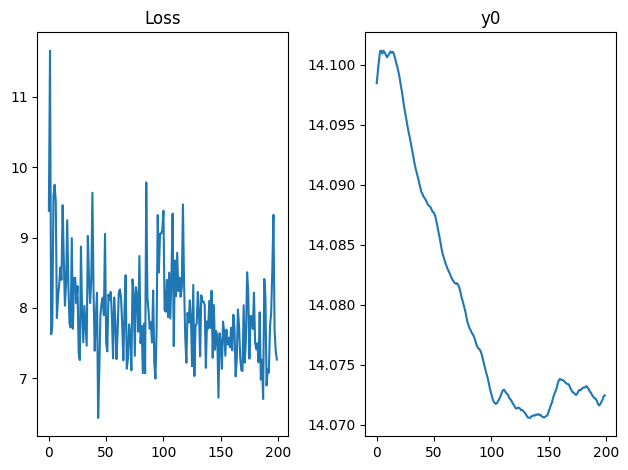

loss:    4.59 y0:   14.07 done:  0.00% Iteration: 0
loss:    5.08 y0:   14.07 done:  5.00% Iteration: 10
loss:    5.53 y0:   14.07 done: 10.00% Iteration: 20
loss:    4.99 y0:   14.07 done: 15.00% Iteration: 30
loss:    4.53 y0:   14.07 done: 20.00% Iteration: 40
loss:    4.54 y0:   14.07 done: 25.00% Iteration: 50
loss:    5.00 y0:   14.07 done: 30.00% Iteration: 60
loss:    4.62 y0:   14.07 done: 35.00% Iteration: 70
loss:    4.96 y0:   14.07 done: 40.00% Iteration: 80
loss:    4.61 y0:   14.07 done: 45.00% Iteration: 90
loss:    4.79 y0:   14.07 done: 50.00% Iteration: 100
loss:    4.93 y0:   14.07 done: 55.00% Iteration: 110
loss:    4.88 y0:   14.07 done: 60.00% Iteration: 120
loss:    4.95 y0:   14.07 done: 65.00% Iteration: 130
loss:    4.76 y0:   14.07 done: 70.00% Iteration: 140
loss:    4.81 y0:   14.08 done: 75.00% Iteration: 150
loss:    4.69 y0:   14.08 done: 80.00% Iteration: 160
loss:    4.67 y0:   14.08 done: 85.00% Iteration: 170
loss:    4.69 y0:   14.08 done: 90.00% 

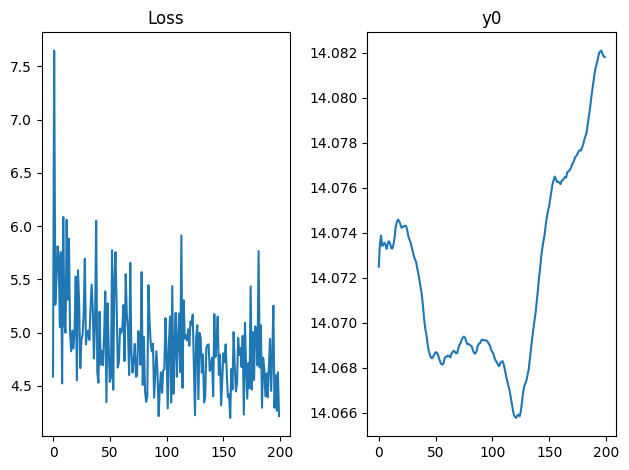

In [10]:
import matplotlib.pyplot as plt

torch.manual_seed(46)
NN = [1,2, 5, 10,20,40]
itrs = [1000,1000,500,500,200,200]
batch_sizes = [100, 100, 100, 100, 1000, 1000]
for N,itr,batch_size in zip(NN,itrs,batch_sizes): 
    loss, y0=bsde_solver.train(batch_size, N,itr, log=True)
    fig, axs = plt.subplots(1,2)
    axs[0].plot(loss)
    axs[0].set_title('Loss')

    axs[1].plot(y0)
    axs[1].set_title('y0')

    plt.tight_layout()
    plt.show()